# Tutorial 2: Analysis of 10X Visium DLPFC data

The following tutorials demonstrates how to use PAST to derive latent embeddings and decipher spatial domains on Slice 151507 of human dorsolateral prefrontal cortex (DLPFC) datasets([Maynard, et al., 2021](https://www.nature.com/articles/s41593-020-00787-0)).

There are two parts in this tutorial:

+ **Integrating self-prior data to analyze Slice 151507.** This part will show you how to utilize target preprocessed gene expression matrix as self-prior matrix to obtain latent embeddings and spatial clusters on Slice 151507 of DLPFC datasets.

+ **Integrating external-prior data to analyze Slice 151507.** This part will show you how to utilize the remaining slices in DLPFC dataset to construct pseudo-bulk external-prior matrix for latent feature extraction and spatial clustering on Slice 151507 of DLPFC datasets.

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the DLPFC dataset in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10X_DLPFC.h5ad

In [4]:
## DLPFC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
DLPFC = sc.read_h5ad(filename="10x_DLPFC.h5ad")
DLPFC.var_names_make_unique()

DLPFC = DLPFC[DLPFC.obs["ManualAnnotation"].astype(str)!="nan", :]
DLPFC_151507 = DLPFC[DLPFC.obs["sample_id"]=="151507", :]
DLPFC_151507

View of AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'ManualAnnotation'
    var: 'source', 'type', 'gene_id', 'gene_version', 'gene_name'
    uns: 'spatial'
    obsm: 'spatial'

## Integrating self-prior matrix to analyze slice 151507

We set a random seed for all random process for reproducibility.

In [5]:
past.setup_seed(666)
sdata = DLPFC_151507.copy()

Next, we filter out genes expressed in less than three spots, follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) tailed for spatial transcriptomics to normalize and logarithmize the count matrix, and then select the top 3000 spatial variable genes based on the [Geary'C Index](https://www.jstor.org/stable/2986645).

In [6]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True, n_tops=3000, gene_method="gearyc")

We initialize PAST model with `d_lat=50`, `k_neighbors=6`.

In [7]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target DLPFC_151507 anndata as self-prior marix.

In [8]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:1.74s Loss: 10.333547
Epoch:20 Time:1.44s Loss: 5.293159
Epoch:30 Time:1.42s Loss: 4.258145
Epoch:40 Time:1.43s Loss: 3.576831
Epoch:50 Time:1.41s Loss: 3.029965
Epoch:60 Time:1.42s Loss: 2.537145
Epoch:70 Time:1.42s Loss: 2.100832
Epoch:80 Time:1.42s Loss: 1.688188
Epoch:90 Time:1.42s Loss: 1.329933
Epoch:100 Time:1.43s Loss: 1.015258
Epoch:110 Time:1.42s Loss: 0.735683
Epoch:120 Time:1.43s Loss: 0.554344
Epoch:130 Time:1.43s Loss: 0.422745
Epoch:140 Time:1.44s Loss: 0.343069
Epoch:150 Time:1.43s Loss: 0.288764
Epoch:160 Time:1.43s Loss: 0.252488
Epoch:170 Time:1.42s Loss: 0.229762
Epoch:180 Time:1.42s Loss: 0.211366
Epoch:190 Time:1.42s Loss: 0.198916
Epoch:200 Time:1.42s Loss: 0.188105
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [9]:
sdata = PAST_model.output(sdata)

The result of mclust and louvain with default resolution is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [10]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["ManualAnnotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [11]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["ManualAnnotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.895, K: 0.871, mF1: 0.874, wF1: 0.894
Mclust metrics:		ARI: 0.541, AMI: 0.680, NMI: 0.680, FMI:0.626, Comp: 0.698, Homo: 0.664
Dlouvain metrics:	ARI: 0.308, AMI: 0.535, NMI: 0.537, FMI:0.415, Comp: 0.462, Homo: 0.641


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

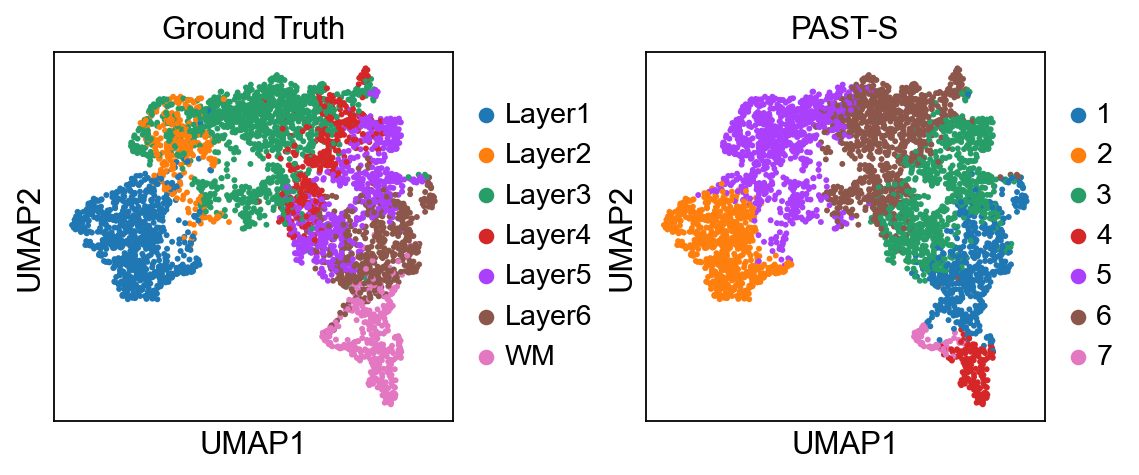

In [12]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["ManualAnnotation", "mclust"], title=["Ground Truth", "PAST-S"], wspace=0.35)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

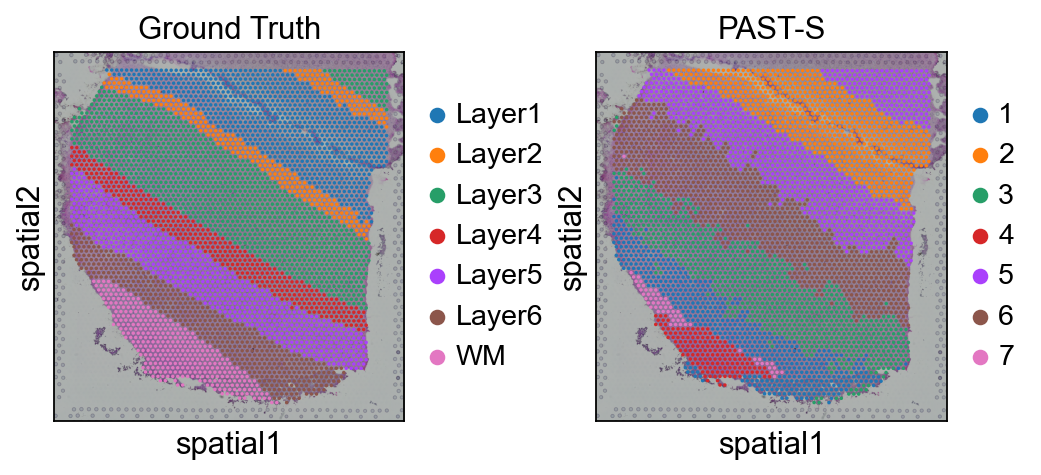

In [13]:
sc.pl.spatial(sdata, color=["ManualAnnotation", "mclust"], library_id="151507", 
              title=["Ground Truth", "PAST-S"])

## Integrating external-prior matrix to analyze slice 151507

Similarly, We set a random seed for all random process for reproducibility.

In [14]:
past.setup_seed(666)
sdata = DLPFC_151507.copy()

As done above, We also filter out genes expressed in less than three spots, follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix, and then select the top 3000 spatial variable genes based on the [Geary'C Index](https://www.jstor.org/stable/2986645).

In [15]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True, n_tops=3000, gene_method="gearyc")

Here we utilize remaining slices in DLPFC dataset as reference data to construct external-prior matrix, denoted as `rdata`. We first align the gene set of `rdata` to that of `sdata` through `past.integration()` function, preprocess `rdata`, and then construct pseudo-bulk external-prior matrix using `past.get_bulk()` function based on spatial domain labels of reference data.

In [16]:
rdata = DLPFC[DLPFC.obs["sample_id"]!="151507", :]
rdata = past.integration(rdata, sdata)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, is_filter_MT=False, n_tops=None)
rdata = past.get_bulk(rdata, key="ManualAnnotation")
rdata

add 0 zero features to reference; Current total 3000 genes
DownSample 1 times to get enough pseudo bulks!
bulk_data's shape: (14, 3000)


AnnData object with n_obs × n_vars = 14 × 3000

We initialize PAST model with the same parameters.

In [17]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST with pseudo-bulk external-prior matrix constructed in the last step.

In [18]:
PAST_model.model_train(sdata, rdata=rdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:1.49s Loss: 10.586530
Epoch:20 Time:1.44s Loss: 5.345097
Epoch:30 Time:1.44s Loss: 4.314612
Epoch:40 Time:1.43s Loss: 3.652286
Epoch:50 Time:1.43s Loss: 3.131180
Epoch:60 Time:1.43s Loss: 2.661607
Epoch:70 Time:1.40s Loss: 2.232972
Epoch:80 Time:1.40s Loss: 1.824615
Epoch:90 Time:1.41s Loss: 1.467374
Epoch:100 Time:1.41s Loss: 1.145516
Epoch:110 Time:1.40s Loss: 0.855051
Epoch:120 Time:1.42s Loss: 0.658578
Epoch:130 Time:1.42s Loss: 0.504797
Epoch:140 Time:1.42s Loss: 0.404679
Epoch:150 Time:1.42s Loss: 0.333332
Epoch:160 Time:1.44s Loss: 0.285568
Epoch:170 Time:1.43s Loss: 0.254855
Epoch:180 Time:1.44s Loss: 0.229411
Epoch:190 Time:1.43s Loss: 0.212267
Epoch:200 Time:1.41s Loss: 0.198867
Model Converge


We then obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [19]:
sdata = PAST_model.output(sdata)

The result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [20]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["ManualAnnotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [21]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["ManualAnnotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "ManualAnnotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.892, K: 0.869, mF1: 0.872, wF1: 0.893
Mclust metrics:		ARI: 0.515, AMI: 0.675, NMI: 0.675, FMI:0.607, Comp: 0.695, Homo: 0.657
Dlouvain metrics:	ARI: 0.556, AMI: 0.676, NMI: 0.677, FMI:0.630, Comp: 0.640, Homo: 0.718


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

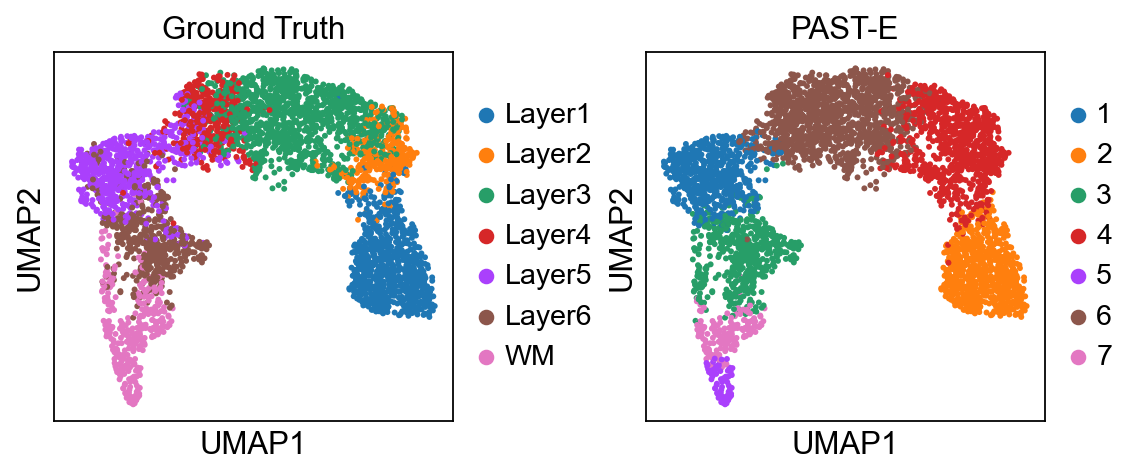

In [22]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["ManualAnnotation", "mclust"], title=["Ground Truth", "PAST-E"], wspace=0.35)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

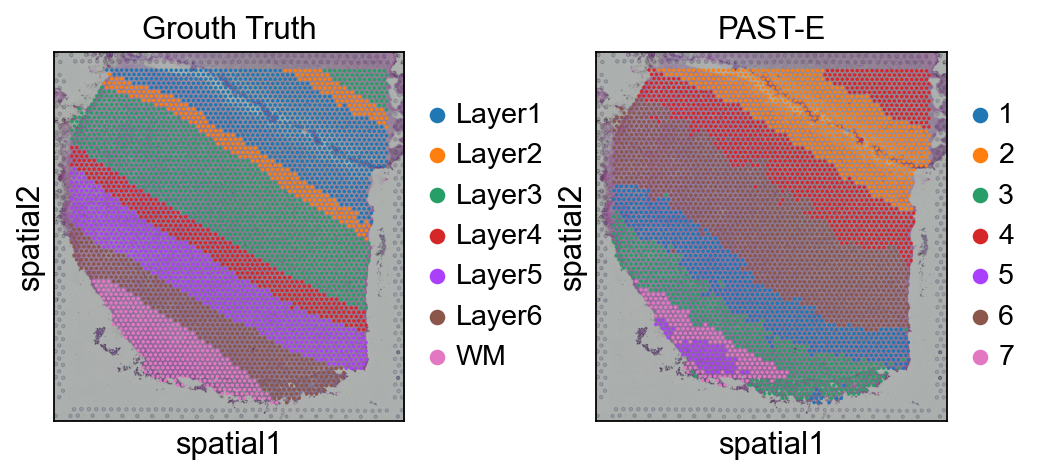

In [23]:
sc.pl.spatial(sdata, color=["ManualAnnotation", "mclust"], library_id="151507",
              title=["Grouth Truth", "PAST-E"])